# **Neural Network From Scratch in Python**

*By Cristian Leo*

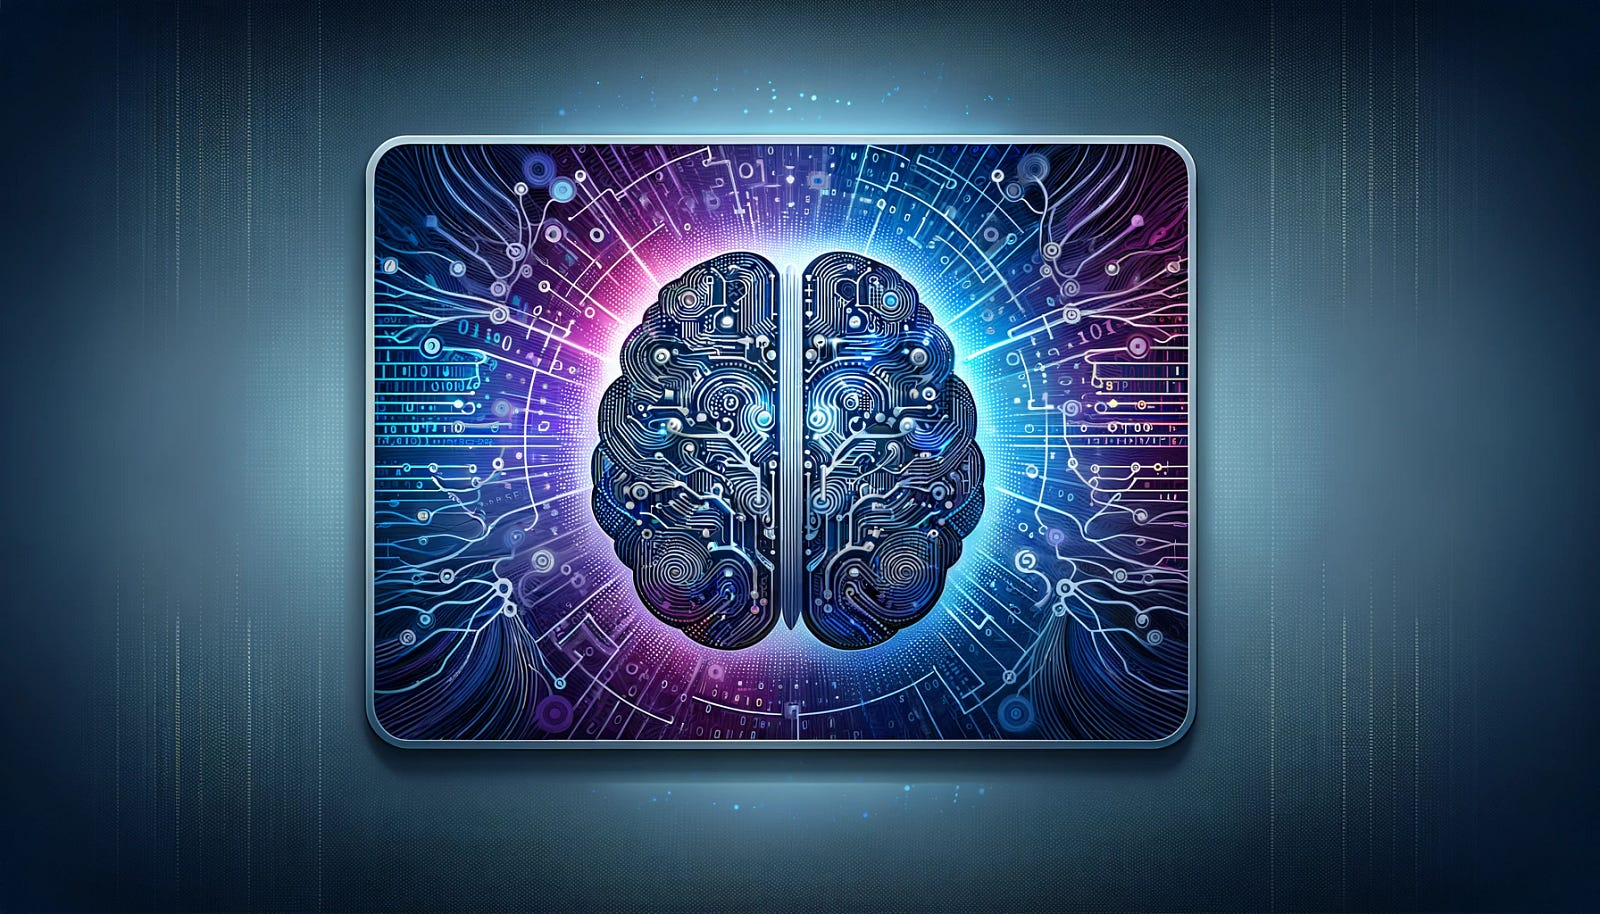

## **Libraries**

In [1]:
import numpy as np # linear algebra

import matplotlib.pyplot as plt # this is used for the plot the graph

from sklearn.datasets import load_digits # this is used for import the dataset
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.preprocessing import MinMaxScaler # for normalization
from sklearn.preprocessing import OneHotEncoder # for one hot encoding

import optuna # for hyperparameter tuning

import warnings # this is used for ignoring the warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Neural Network Class**

In [2]:
class NeuralNetwork:
    """
    A simple neural network with one hidden layer.

    Parameters:
    -----------
    input_size: int
        The number of input features
    hidden_size: int
        The number of neurons in the hidden layer
    output_size: int
        The number of neurons in the output layer
    loss_func: str
        The loss function to use. Options are 'mse' for mean squared error, 'log_loss' for logistic loss, and 'categorical_crossentropy' for categorical crossentropy.
    """
    def __init__(self, input_size, hidden_size, output_size, loss_func='mse'):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.loss_func = loss_func
        
        # Initialize weights and biases
        self.weights1 = np.random.randn(self.input_size, self.hidden_size)
        self.bias1 = np.zeros((1, self.hidden_size))
        self.weights2 = np.random.randn(self.hidden_size, self.output_size)
        self.bias2 = np.zeros((1, self.output_size))

        # track loss
        self.train_loss = []
        self.test_loss = []

    def __str__(self):
        """
        Print the neural network architecture.
        """
        return f"Neural Network Layout:\nInput Layer: {self.input_size} neurons\nHidden Layer: {self.hidden_size} neurons\nOutput Layer: {self.output_size} neurons\nLoss Function: {self.loss_func}"
        
    def forward(self, X):
        """
        Perform forward propagation.
        
        Parameters:
        -----------
        X: numpy array
            The input data
        
        Returns:
        --------
        numpy array
            The predicted output
        """
        # Perform forward propagation
        self.z1 = np.dot(X, self.weights1) + self.bias1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.weights2) + self.bias2
        if self.loss_func == 'categorical_crossentropy':
            self.a2 = self.softmax(self.z2)
        else:
            self.a2 = self.sigmoid(self.z2)
        return self.a2
    
    def backward(self, X, y, learning_rate):
        """
        Perform backpropagation.

        Parameters:
        -----------
        X: numpy array
            The input data
        y: numpy array
            The target output
        learning_rate: float
            The learning rate
        """
        # Perform backpropagation
        m = X.shape[0]
        
        # Calculate gradients
        if self.loss_func == 'mse':
            self.dz2 = self.a2 - y
        elif self.loss_func == 'log_loss':
            self.dz2 = -(y/self.a2 - (1-y)/(1-self.a2))
        elif self.loss_func == 'categorical_crossentropy':
            self.dz2 = self.a2 - y
        else:
            raise ValueError('Invalid loss function')
        
        self.dw2 = (1 / m) * np.dot(self.a1.T, self.dz2)
        self.db2 = (1 / m) * np.sum(self.dz2, axis=0, keepdims=True)
        self.dz1 = np.dot(self.dz2, self.weights2.T) * self.sigmoid_derivative(self.a1)
        self.dw1 = (1 / m) * np.dot(X.T, self.dz1)
        self.db1 = (1 / m) * np.sum(self.dz1, axis=0, keepdims=True)
        
        # Update weights and biases
        self.weights2 -= learning_rate * self.dw2
        self.bias2 -= learning_rate * self.db2
        self.weights1 -= learning_rate * self.dw1
        self.bias1 -= learning_rate * self.db1
        
    def sigmoid(self, x):
        """
        Sigmoid activation function.
        
        Parameters:
        -----------
        x: numpy array
            The input data
        
        Returns:
        --------
        numpy array
            The output of the sigmoid function
        """
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        """
        Derivative of the sigmoid activation function.

        Parameters:
        -----------
        x: numpy array
            The input data
        
        Returns:
        --------
        numpy array
            The output of the derivative of the sigmoid function
        """
        return x * (1 - x)
    
    def softmax(self, x):
        """
        Softmax activation function.

        Parameters:
        -----------
        x: numpy array
            The input data
        
        Returns:
        --------
        numpy array
            The output of the softmax function
        """
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps/np.sum(exps, axis=1, keepdims=True)

## **Trainer Class**

In [3]:
class Trainer:
    """
    A class to train a neural network.

    Parameters:
    -----------
    model: NeuralNetwork
        The neural network model to train
    loss_func: str
        The loss function to use. Options are 'mse' for mean squared error, 'log_loss' for logistic loss, and 'categorical_crossentropy' for categorical crossentropy.
    """
    def __init__(self, model, loss_func='mse'):
        self.model = model
        self.loss_func = loss_func
        self.train_loss = []
        self.test_loss = []

    def calculate_loss(self, y_true, y_pred):
        """
        Calculate the loss.

        Parameters:
        -----------
        y_true: numpy array
            The true output
        y_pred: numpy array
            The predicted output
        
        Returns:
        --------
        float
            The loss
        """
        if self.loss_func == 'mse':
            return np.mean((y_pred - y_true)**2)
        elif self.loss_func == 'log_loss':
            return -np.mean(y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred))
        elif self.loss_func == 'categorical_crossentropy':
            return -np.mean(y_true*np.log(y_pred))
        else:
            raise ValueError('Invalid loss function')

    def train(self, X_train, y_train, X_test, y_test, epochs, learning_rate):
        """
        Train the neural network.

        Parameters:
        -----------
        X_train: numpy array
            The training input data
        y_train: numpy array
            The training target output
        X_test: numpy array
            The test input data
        y_test: numpy array
            The test target output
        epochs: int
            The number of epochs to train the model
        learning_rate: float
            The learning rate
        """
        for _ in range(epochs):
            self.model.forward(X_train)
            self.model.backward(X_train, y_train, learning_rate)
            train_loss = self.calculate_loss(y_train, self.model.a2)
            self.train_loss.append(train_loss)
            
            self.model.forward(X_test)
            test_loss = self.calculate_loss(y_test, self.model.a2)
            self.test_loss.append(test_loss)

## **Load Dataset**

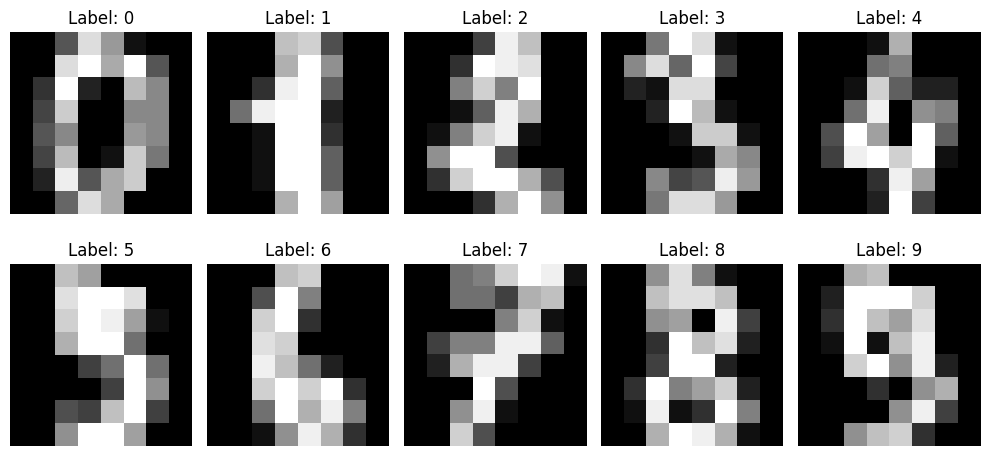

In [4]:
# Load the digits dataset
digits = load_digits()

# Plot the first 10 images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(digits.images[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Label: {digits.target[i]}")

plt.tight_layout()
plt.show()

## **Data Preprocessing**

In [5]:
# Preprocess the dataset
scaler = MinMaxScaler()
X = scaler.fit_transform(digits.data)
y = digits.target

# One-hot encode the target output
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

## **Create Neural Network**

In [6]:
# Create an instance of the NeuralNetwork class
input_size = X.shape[1]
hidden_size = 64
output_size = len(np.unique(y))
loss_func = 'categorical_crossentropy'
epochs = 1000
learning_rate = 0.1

nn = NeuralNetwork(input_size, hidden_size, output_size, loss_func)

# Print the neural network artchitecture
print(nn)

Neural Network Layout:
Input Layer: 64 neurons
Hidden Layer: 64 neurons
Output Layer: 10 neurons
Loss Function: categorical_crossentropy


## **Train NN**

In [7]:
trainer = Trainer(nn, loss_func)
trainer.train(X_train, y_train, X_test, y_test, epochs, learning_rate)

# Convert y_test from one-hot encoding to labels
y_test_labels = np.argmax(y_test, axis=1)

# Evaluate the performance of the neural network
predictions = np.argmax(nn.forward(X_test), axis=1)
accuracy = np.mean(predictions == y_test_labels)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 93.33%


## **Plot Loss**

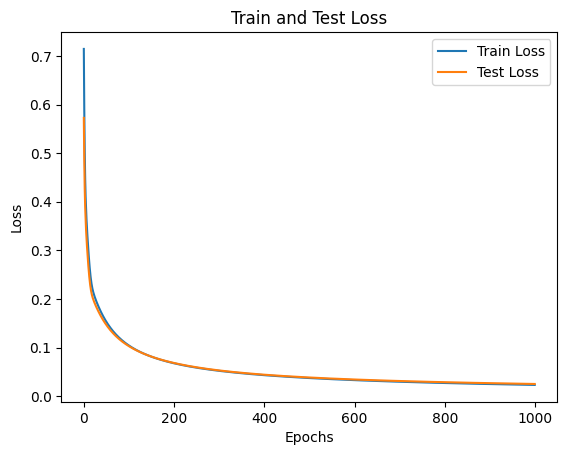

In [8]:
plt.plot(trainer.train_loss, label='Train Loss')
plt.plot(trainer.test_loss, label='Test Loss')
plt.title('Train and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **Fine-Tune NN**

In [9]:
def objective(trial):
    # Define hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 32, 128)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
    epochs = trial.suggest_int('epochs', 500, 10000)

    # Create and train the neural network
    nn = NeuralNetwork(input_size, hidden_size, output_size, loss_func)
    trainer = Trainer(nn, loss_func)
    trainer.train(X_train, y_train, X_test, y_test, epochs, learning_rate)

    # Evaluate the performance of the neural network
    predictions = np.argmax(nn.forward(X_test), axis=1)
    accuracy = np.mean(predictions == y_test_labels)

    return accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(study_name='nn_study', direction='maximize')
study.optimize(objective, n_trials=10)

# Print the best hyperparameters
print(f"Best trial: {study.best_trial.params}")
print(f"Best value: {study.best_trial.value}")

[I 2024-03-25 21:25:03,832] A new study created in memory with name: nn_study
[I 2024-03-25 21:27:52,993] Trial 0 finished with value: 0.9666666666666667 and parameters: {'hidden_size': 55, 'learning_rate': 0.043181890117968594, 'epochs': 7767}. Best is trial 0 with value: 0.9666666666666667.
[I 2024-03-25 21:30:29,852] Trial 1 finished with value: 0.21388888888888888 and parameters: {'hidden_size': 53, 'learning_rate': 0.00024757383393530526, 'epochs': 9134}. Best is trial 0 with value: 0.9666666666666667.
[I 2024-03-25 21:32:09,488] Trial 2 finished with value: 0.16944444444444445 and parameters: {'hidden_size': 97, 'learning_rate': 0.00038955617273236985, 'epochs': 4964}. Best is trial 0 with value: 0.9666666666666667.
[I 2024-03-25 21:32:26,650] Trial 3 finished with value: 0.13055555555555556 and parameters: {'hidden_size': 91, 'learning_rate': 0.00016455567772291505, 'epochs': 940}. Best is trial 0 with value: 0.9666666666666667.
[I 2024-03-25 21:34:14,600] Trial 4 finished with 

Best trial: {'hidden_size': 55, 'learning_rate': 0.043181890117968594, 'epochs': 7767}
Best value: 0.9666666666666667


## **Predict**

In [10]:
best_nn = NeuralNetwork(input_size, study.best_trial.params['hidden_size'], output_size, loss_func)
best_trainer = Trainer(best_nn, loss_func)
best_trainer.train(X_train, y_train, X_test, y_test, study.best_trial.params['epochs'], study.best_trial.params['learning_rate'])

# Evaluate the performance of the best neural network
predictions = np.argmax(best_nn.forward(X_test), axis=1)
accuracy = np.mean(predictions == y_test_labels)
print(f"Best accuracy: {accuracy:.2%}")

Best accuracy: 96.67%
